# Assignment 7


## Required Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import time

## Supervised Learning Problem Description

This project will analyze the NYPD Shooting Incident Data data set features in an attemt to classify incidents as a murder.  THree different classification modles will be built and the calssification accuracy compared againt various model parameters. The K-Nearest Neighbors, Random Forest and Gradient Boosting Classifiers from the sklearn packed will be evaluated. The features of the data set will be converted from muti-value to binary and a feature importance evaluation will be included. A comparasion of computation time will be included to assess the best balance between performance and time.

The dataset being used is the NYPD SHooting Incident Data (Historic).  The source file is lcated at https://catalog.data.gov/dataset/nypd-shooting-incident-data-historic.  The data contains information on every shooting incident that occured in New York City from 1/1/2006 through 12/31/2021.  The data includes features related to the location and time of incident, perpetrator and victim attributes and  murder label.  The murder label (SATISTICAL_MURDER_FLAG) indicates a shooting that results in the victim's death and counted as a murder.

### EDA
#### Import Data and High Level Analysis

In [17]:
orginalDataSet = pd.read_csv('data/NYPD_Shooting_Incident_Data__Historic_.csv')
orginalDataSet.describe()

print("Shape: " + str(orginalDataSet.shape))
print("Row Count: " + str(len(orginalDataSet)))
print(orginalDataSet.head(5))
print(orginalDataSet.describe(percentiles = [], include='all'))
print(orginalDataSet.dtypes)

Shape: (25596, 19)
Row Count: 25596
   INCIDENT_KEY  OCCUR_DATE OCCUR_TIME      BORO  PRECINCT  JURISDICTION_CODE  \
0     236168668  11/11/2021   15:04:00  BROOKLYN        79                0.0   
1     231008085  07/16/2021   22:05:00  BROOKLYN        72                0.0   
2     230717903  07/11/2021   01:09:00  BROOKLYN        79                0.0   
3     237712309  12/11/2021   13:42:00  BROOKLYN        81                0.0   
4     224465521  02/16/2021   20:00:00    QUEENS       113                0.0   

  LOCATION_DESC  STATISTICAL_MURDER_FLAG PERP_AGE_GROUP PERP_SEX  \
0           NaN                    False            NaN      NaN   
1           NaN                    False          45-64        M   
2           NaN                    False            <18        M   
3           NaN                    False            NaN      NaN   
4           NaN                    False            NaN      NaN   

                  PERP_RACE VIC_AGE_GROUP VIC_SEX                  V

#### High Level Observations
The following features contain NAs:
    LOCATION_DESC
    PERP_AGE_GROUP
    PERP_SEX
    PERP_RACE

The OCCUR_DATE and OCCUR_TIME are object types not datetime types.

The data will be assessed for the level of NA occurances.

In [18]:
nullValues = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
for c in orginalDataSet.columns:
    string_null = np.array([x in nullValues[2:] for x in orginalDataSet[c]])
    print(c, orginalDataSet[c].isnull().sum(), string_null.sum())

INCIDENT_KEY 0 0
OCCUR_DATE 0 0
OCCUR_TIME 0 0
BORO 0 0
PRECINCT 0 0
JURISDICTION_CODE 2 0
LOCATION_DESC 14977 0
STATISTICAL_MURDER_FLAG 0 0
PERP_AGE_GROUP 9344 0
PERP_SEX 9310 0
PERP_RACE 9310 0
VIC_AGE_GROUP 0 0
VIC_SEX 0 0
VIC_RACE 0 0
X_COORD_CD 0 0
Y_COORD_CD 0 0
Latitude 0 0
Longitude 0 0
Lon_Lat 0 0


Based on the NA assessment the following features can be thrown.  (NA count > 5%)

    LOCATION_DESC
    PERP_AGE_GROUP
    PERP_SEX
    PERP_RACE
   
Addtionally, the following features are deememd either redundant or irrelevelvant to the analysis.

    INCIDENT_KEY
    PRECINCT
    JURISDICTION_CODE
    X_COORD_CD
    Y_COORD_CD
    Latitude
    Longitude
    Lon_Lat

In [19]:
featuresToThrow = ['INCIDENT_KEY', 'PRECINCT', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat', 'LOCATION_DESC', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE']
orginalDataSet.drop(featuresToThrow, axis=1, inplace=True)
print("Shape: " + str(orginalDataSet.shape))
print("Row Count: " + str(len(orginalDataSet)))
print(orginalDataSet.dtypes)

Shape: (25596, 7)
Row Count: 25596
OCCUR_DATE                 object
OCCUR_TIME                 object
BORO                       object
STATISTICAL_MURDER_FLAG      bool
VIC_AGE_GROUP              object
VIC_SEX                    object
VIC_RACE                   object
dtype: object


The OCCUR_OCCUR_DATE is converted to date time object and broken into month and day features.
The OCCUR_TIME feature is broken out into hour of the day

In [20]:
orginalDataSet['OCCUR_DATE']= pd.to_datetime(orginalDataSet['OCCUR_DATE'])
orginalDataSet['hour'] = orginalDataSet['OCCUR_TIME'].astype(str).str[0]
orginalDataSet['hour'] = orginalDataSet['hour'].astype(int)
orginalDataSet['day'] = orginalDataSet['OCCUR_DATE'].dt.dayofweek
orginalDataSet['month'] = orginalDataSet['OCCUR_DATE'].dt.month
print(orginalDataSet.dtypes)

OCCUR_DATE                 datetime64[ns]
OCCUR_TIME                         object
BORO                               object
STATISTICAL_MURDER_FLAG              bool
VIC_AGE_GROUP                      object
VIC_SEX                            object
VIC_RACE                           object
hour                                int32
day                                 int64
month                               int64
dtype: object


#### Feature Value Assesment
Feature values will be evalauted via unique value and hisogram assessment for completeness and correctness.

In [21]:
boroughs = orginalDataSet.BORO.unique()
murderFlag = orginalDataSet.STATISTICAL_MURDER_FLAG.unique()
victimAgeGroup = orginalDataSet.VIC_AGE_GROUP.unique()
victimSex = orginalDataSet.VIC_SEX.unique()
victimRace = orginalDataSet.VIC_RACE.unique()

print(boroughs)
print(murderFlag)
print(victimAgeGroup)
print(victimSex)
print(victimRace)

['BROOKLYN' 'QUEENS' 'BRONX' 'MANHATTAN' 'STATEN ISLAND']
[False  True]
['18-24' '25-44' '<18' '45-64' '65+' 'UNKNOWN']
['M' 'F' 'U']
['BLACK' 'ASIAN / PACIFIC ISLANDER' 'BLACK HISPANIC' 'WHITE HISPANIC'
 'WHITE' 'AMERICAN INDIAN/ALASKAN NATIVE' 'UNKNOWN']


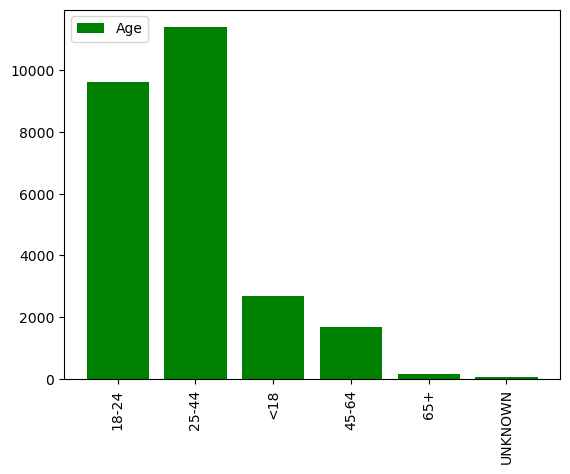

In [22]:
plt.xticks(rotation='vertical')
ageHistogram = list(orginalDataSet['VIC_AGE_GROUP'])
ageDict = {x:ageHistogram.count(x) for x in ageHistogram}
plt.bar(ageDict.keys(), ageDict.values(), color='g')
plt.legend(['Age'], loc=2)

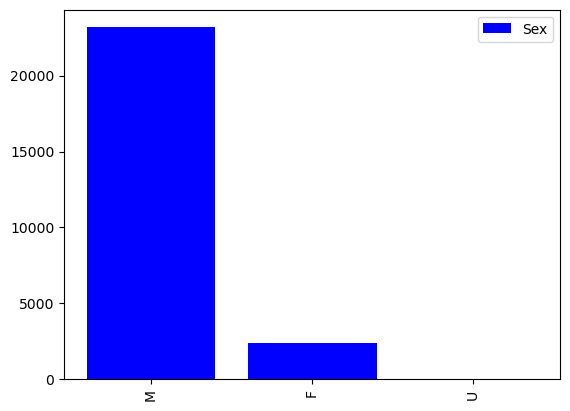

In [23]:
plt.xticks(rotation='vertical')
sexHistogram = list(orginalDataSet['VIC_SEX'])
sexDict = {x:sexHistogram.count(x) for x in sexHistogram}
plt.bar(sexDict.keys(), sexDict.values(), color='b')
plt.legend(["Sex"], loc=1)

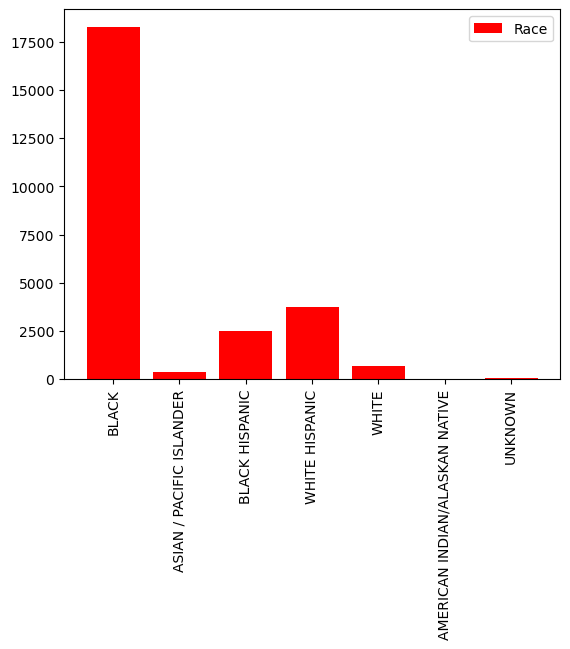

In [24]:
plt.xticks(rotation='vertical')
raceHistogram = list(orginalDataSet['VIC_RACE'])
raceDict = {x:raceHistogram.count(x) for x in raceHistogram}
plt.bar(raceDict.keys(), raceDict.values(), color='r')
plt.legend(["Race"], loc=1)

The feature value analysis showed that VIC_AGE_GROUP, VIC_SEX, VIC_RACE contained U and UNKNOWN Values. The degree to which these values impact the data set was assessed via percent of observations and the above histograms.

In [25]:
unknownAgeRows = orginalDataSet.apply(lambda x: True if x['VIC_AGE_GROUP'] == 'UNKNOWN' else False, axis = 1)
print('Unknown Age Rows: ' + str(len(unknownAgeRows[unknownAgeRows == True].index)))
print('Percent of Rows: ' + str(len(unknownAgeRows[unknownAgeRows == True].index)/len(orginalDataSet)))

unknownSexRows = orginalDataSet.apply(lambda x: True if x['VIC_SEX'] == 'U' else False, axis = 1)
print('Unknown Sex Rows: ' + str(len(unknownSexRows[unknownSexRows == True].index)))
print('Percent of Rows: ' + str(len(unknownSexRows[unknownSexRows == True].index)/len(orginalDataSet)))

unknownRaceRows = orginalDataSet.apply(lambda x: True if x['VIC_RACE'] == 'UNKNOWN' else False, axis = 1)
print('Unknown Age Rows: ' + str(len(unknownRaceRows[unknownRaceRows == True].index)))
print('Percent of Rows: ' + str(len(unknownRaceRows[unknownRaceRows == True].index)/len(orginalDataSet)))

Unknown Age Rows: 60
Percent of Rows: 0.0023441162681669013
Unknown Sex Rows: 11
Percent of Rows: 0.0004297546491639319
Unknown Age Rows: 65
Percent of Rows: 0.0025394592905141427


The results revealed that <.5% of the observations are impacted and can be removed.  Removal was validated.

In [26]:
indexAge = orginalDataSet[ (orginalDataSet['VIC_AGE_GROUP'] == 'UNKNOWN')].index
orginalDataSet.drop(indexAge, inplace=True)

indexSex = orginalDataSet[ (orginalDataSet['VIC_SEX'] == 'U')].index
orginalDataSet.drop(indexSex, inplace=True)

indexRace = orginalDataSet[ (orginalDataSet['VIC_RACE'] == 'UNKNOWN')].index
orginalDataSet.drop(indexRace, inplace=True)

#Verfiy rows removed
victimAgeGroup = orginalDataSet.VIC_AGE_GROUP.unique()
victimSex = orginalDataSet.VIC_SEX.unique()
victimRace = orginalDataSet.VIC_RACE.unique()

print(victimAgeGroup)
print(victimSex)
print(victimRace)

print("Row Count: " + str(len(orginalDataSet)))

['18-24' '25-44' '<18' '45-64' '65+']
['M' 'F']
['BLACK' 'ASIAN / PACIFIC ISLANDER' 'BLACK HISPANIC' 'WHITE HISPANIC'
 'WHITE' 'AMERICAN INDIAN/ALASKAN NATIVE']
Row Count: 25482


#### Build Classification Dataframe

With the orginal data set cleansed, the dataset was converted from multi value features to binary features.  The result being an increase of features from 10 to 61.  For illustration purposes the first 10 rows of the classification data set are provided.

In [27]:
classificationData = pd.DataFrame()

classificationData['murder'] = orginalDataSet['STATISTICAL_MURDER_FLAG']
#0 for female, 1 for male
classificationData['sex'] = [False if x == 'F' else True for x in orginalDataSet['day']]

#Map multivalue features to boolean feature columns
#day of week
for d in range(7):
    header = 'd' + str(d)
    classificationData[header] = [True if x == d else False for x in orginalDataSet['day']]
#hour of day
for h in range(24):
    header = 'h' + str(h)
    classificationData[header] = [True if x == h else False for x in orginalDataSet['hour']]

#month of year
for m in range(1,13):
    header = 'm' + str(m)
    classificationData[header] = [True if x == m else False for x in orginalDataSet['month']]

for b in boroughs:
    classificationData[b] = [True if x == b else False for x in orginalDataSet['BORO']]

for r in victimRace:
    classificationData[r] = [True if x == r else False for x in orginalDataSet['VIC_RACE']]

for a in victimAgeGroup :
    classificationData[a] = [True if x == a else False for x in orginalDataSet['VIC_AGE_GROUP']]


classificationData.info()
print(classificationData.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25482 entries, 0 to 25595
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   murder                          25482 non-null  bool 
 1   sex                             25482 non-null  bool 
 2   d0                              25482 non-null  bool 
 3   d1                              25482 non-null  bool 
 4   d2                              25482 non-null  bool 
 5   d3                              25482 non-null  bool 
 6   d4                              25482 non-null  bool 
 7   d5                              25482 non-null  bool 
 8   d6                              25482 non-null  bool 
 9   h0                              25482 non-null  bool 
 10  h1                              25482 non-null  bool 
 11  h2                              25482 non-null  bool 
 12  h3                              25482 non-null  bool 
 13  h

### Analysis
#### Models and Training

Train and test data sets were generated (75% train / 25% test) and the three models built and output provided.  The KNN model was assessed for 20 differen k values beginning at 2.  The Random Forest and Gradient Boost models were evaluated for 20 different learner values ranging from 25 to 500, at intervals of 50.  Accuracy and computation times were collected for each model at each of the conditions.

Each model consisted of 20 different condition sets so that the a side by side classification accurracy could be evaluated.  The time for each model condition was also captured for comparison purposes.

The results of the evaluations are provided.

In [28]:
y = classificationData['murder']
X = classificationData.drop(['murder'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

dfAccuracy = pd.DataFrame()
dfTimes = pd.DataFrame()

#KNN Evaluation
knnStartTime = time.time()

knnScores = [None]
knnTimes =[None]
for k in range(2, 22):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knnPredictions = knn.predict(X_test)
    knnScores.append(metrics.accuracy_score(y_test, knnPredictions))
    knnTimes.append(time.time() - knnStartTime)

dfAccuracy['KNN'] = knnScores
dfTimes['KNN'] = knnTimes

#Random Forest
forestStartTime = time.time()

estimators = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]
forestScores = [None]
forestTimes = [None]
for e in estimators:
    forest = RandomForestClassifier(n_estimators=e)
    forest.fit(X_train, y_train)
    forestPredictions = forest.predict(X_test)
    forestScores.append(metrics.accuracy_score(y_test, forestPredictions))
    forestTimes.append(time.time() - forestStartTime)

dfAccuracy['Forest'] = forestScores
dfTimes['Forest'] = forestTimes

#Gradient Boost
boostStartTime = time.time()

boostScores = [None]
boostTimes = [None]
for e in estimators:
    boost = GradientBoostingClassifier(n_estimators=e)
    boost.fit(X_train, y_train)
    boostPredictions = boost.predict(X_test)
    boostScores.append(metrics.accuracy_score(y_test, boostPredictions))
    boostTimes.append(time.time() - boostStartTime)

dfAccuracy['Boost'] = boostScores
dfTimes['Boost'] = boostTimes

print("Table1: Accuracy Scores")
print(dfAccuracy)

print("Table2: Computation Times (seconds)")
print(dfTimes)

Accuracy Scores
         KNN    Forest     Boost
0        NaN       NaN       NaN
1   0.793753  0.775075  0.816198
2   0.753257  0.779313  0.816041
3   0.795636  0.781353  0.815571
4   0.777429  0.779156  0.815571
5   0.806938  0.782138  0.815728
6   0.798619  0.780411  0.815414
7   0.809606  0.781667  0.815571
8   0.805211  0.783237  0.815728
9   0.812431  0.782452  0.815728
10  0.807879  0.783394  0.814629
11  0.814315  0.783707  0.814472
12  0.812117  0.785277  0.815571
13  0.814158  0.783237  0.814629
14  0.813216  0.782609  0.815100
15  0.814786  0.786219  0.814943
16  0.813844  0.783550  0.814943
17  0.815414  0.786062  0.814472
18  0.814786  0.784492  0.814786
19  0.815414  0.785277  0.815257
20  0.815257  0.785434  0.815100
Computation Times (seconds)
          KNN      Forest       Boost
0         NaN         NaN         NaN
1    8.890177    0.829854    0.526413
2   12.192501    1.965973    1.480657
3   15.779120    3.609852    2.935243
4   19.131686    5.714602    4.747185
5 

In [ ]:
Plots were generated to compare models.

Plot 1:  Accuracy Plot


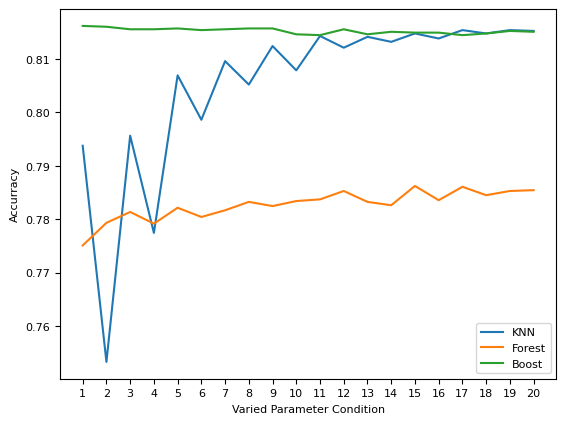

Plot 2:  Computation Time Plot


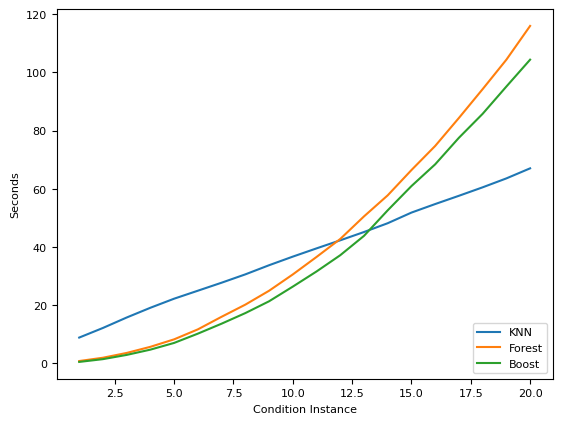

In [59]:
xLabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

print('Plot 1:  Accuracy Plot')
plt.plot(dfAccuracy['KNN'])
plt.plot(dfAccuracy['Forest'])
plt.plot(dfAccuracy['Boost'])
plt.xlabel('Varied Parameter Condition')
plt.ylabel('Accurracy')
plt.legend(['KNN', 'Forest', 'Boost'], loc=4)
plt.xticks(xLabels)
plt.show()


print('Plot 2:  Computation Time Plot')
plt.plot(dfTimes['KNN'])
plt.plot(dfTimes['Forest'])
plt.plot(dfTimes['Boost'])
plt.xlabel('Condition Instance')
plt.ylabel('Seconds')
plt.legend(['KNN', 'Forest', 'Boost'], loc=4)
plt.show()

#### Feature Importance
A features importance test was performed on the dataset to assess the relevence of the 61 features and to assess impact on model performance

<function matplotlib.pyplot.show(close=None, block=None)>

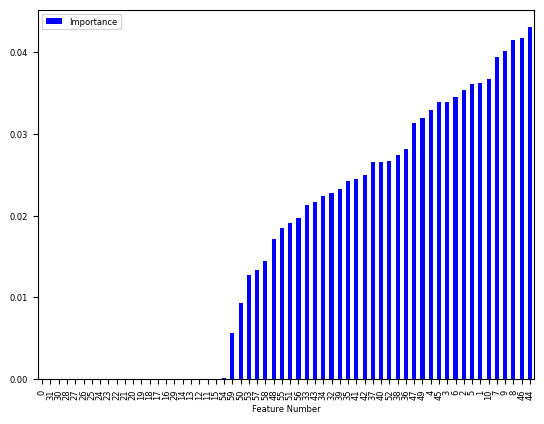

In [33]:
featureImportanceForest = RandomForestClassifier(n_estimators=300)
featureImportanceForest.fit(X_train, y_train)
featureImportance = featureImportanceForest.feature_importances_
importantanceDf = pd.DataFrame({"Feature": pd.DataFrame(X_train).columns, "Importance": featureImportance})
importantanceDf.set_index('Importance')
importantanceDf = importantanceDf.sort_values('Importance')
importantanceDf.plot.bar(color = 'blue')
plt.xlabel('Feature Number')
plt.rc('font', size=4) 
plt.show

The feature importance assessment showed that sex and most of the hours of the day have no impact on the model.  These features will be removed and the models run with the smaller feature set. For illustration purposes the first 10 rows of the classification data set are provided.

In [36]:
featuresZeroImportance = importantanceDf[importantanceDf['Importance'] < .0001]
print(featuresZeroImportance)
featuresToRemove = list(featuresZeroImportance['Feature'])
print(featuresToRemove)

print('Create Important Feature Dataframe')
dfInportantFeatures = classificationData.drop(featuresToRemove, axis = 1)
dfInportantFeatures.info()
print(dfInportantFeatures.head(10))

   Feature  Importance
0      sex         0.0
31     h23         0.0
30     h22         0.0
28     h20         0.0
27     h19         0.0
26     h18         0.0
25     h17         0.0
24     h16         0.0
23     h15         0.0
22     h14         0.0
21     h13         0.0
20     h12         0.0
19     h11         0.0
18     h10         0.0
17      h9         0.0
16      h8         0.0
29     h21         0.0
14      h6         0.0
13      h5         0.0
12      h4         0.0
11      h3         0.0
15      h7         0.0
['sex', 'h23', 'h22', 'h20', 'h19', 'h18', 'h17', 'h16', 'h15', 'h14', 'h13', 'h12', 'h11', 'h10', 'h9', 'h8', 'h21', 'h6', 'h5', 'h4', 'h3', 'h7']
Create Important Feature Dataframe
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25482 entries, 0 to 25595
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   murder                          25482 non-null  bool 
 1

### Results
Rerun models with reduced feature data set and compare.

In [60]:
y = dfInportantFeatures['murder']
X = dfInportantFeatures.drop(['murder'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

knnImportantFeatuesStartTime = time.time()

knnImportantFeatuesScores = [None]
knnImportantFeatuesTimes = [None]
for k in range(2, 22):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knnImportantFeatuesPredictions = knn.predict(X_test)
    knnImportantFeatuesScores.append(metrics.accuracy_score(y_test, knnImportantFeatuesPredictions))
    knnImportantFeatuesTimes.append(time.time() - knnImportantFeatuesStartTime)

dfAccuracy['IF_KNN'] = knnImportantFeatuesScores
dfTimes['IF_KNN'] = knnImportantFeatuesTimes

forestImportantFeatuesStartTime = time.time()

forestImportantFeaturesScores = [None]
forestImportantFeaturesTimes = [None]
for e in estimators:
    forest = RandomForestClassifier(n_estimators=e)
    forest.fit(X_train, y_train)
    forestImportantFeatuesPredictions = forest.predict(X_test)
    forestImportantFeaturesScores.append(metrics.accuracy_score(y_test, forestImportantFeatuesPredictions))
    forestImportantFeaturesTimes.append(time.time() - forestImportantFeatuesStartTime)

dfAccuracy['IF_Forest'] = forestImportantFeaturesScores
dfTimes['IF_Forest'] = forestImportantFeaturesTimes


boostImportantFeatuesStartTime = time.time()

boostImportantFeaturesScores = [None]
boostImportantFeaturesTimes = [None]
for e in estimators:
    boost = GradientBoostingClassifier(n_estimators=e)
    boost.fit(X_train, y_train)
    boostImportantFeaturesPredictions = boost.predict(X_test)
    boostImportantFeaturesScores.append(metrics.accuracy_score(y_test, boostImportantFeaturesPredictions))
    boostImportantFeaturesTimes.append(time.time() - boostImportantFeatuesStartTime)

dfAccuracy['IF_Boost'] = boostImportantFeaturesScores
dfTimes['IF_Boost'] = boostImportantFeaturesTimes

print("Table 3: Accuracy Scores")
print(dfAccuracy)
print("")
print("Table 4: Computation Times (seconds)")
print(dfTimes)

Table 1: Accuracy Scores
         KNN    Forest     Boost    IF_KNN  IF_Forest  IF_Boost
0        NaN       NaN       NaN       NaN        NaN       NaN
1   0.793753  0.775075  0.816198  0.793753   0.775545  0.816041
2   0.753257  0.779313  0.816041  0.753257   0.780254  0.815884
3   0.795636  0.781353  0.815571  0.795636   0.780254  0.815571
4   0.777429  0.779156  0.815571  0.777429   0.780725  0.815728
5   0.806938  0.782138  0.815728  0.806938   0.780882  0.815728
6   0.798619  0.780411  0.815414  0.798619   0.781667  0.815728
7   0.809606  0.781667  0.815571  0.809606   0.783080  0.815414
8   0.805211  0.783237  0.815728  0.805211   0.784335  0.815100
9   0.812431  0.782452  0.815728  0.812431   0.783550  0.814786
10  0.807879  0.783394  0.814629  0.807879   0.783550  0.814472
11  0.814315  0.783707  0.814472  0.814315   0.783550  0.814472
12  0.812117  0.785277  0.815571  0.812117   0.783864  0.814315
13  0.814158  0.783237  0.814629  0.814158   0.782295  0.814629
14  0.813216  0

#### Reduced Feature Plots

Plot 3:  Reduced Feature Set Accuracy Plot


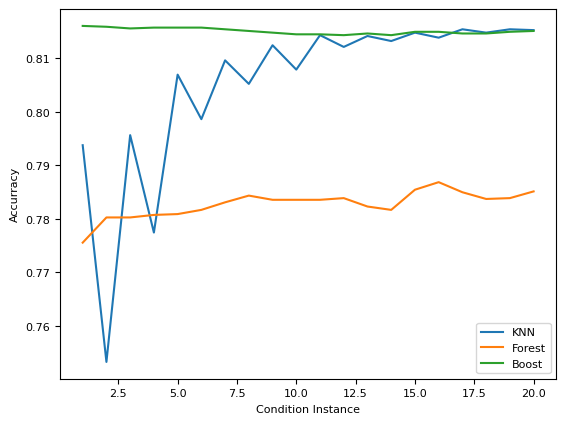

Plot 4:  Reduced Feature Set Computation Time Plot


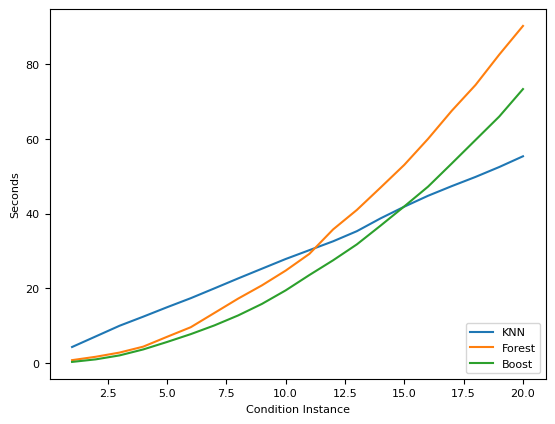

In [64]:
plt.rc('font', size=8)

print('Plot 3:  Reduced Feature Set Accuracy Plot')
plt.plot(dfAccuracy['IF_KNN'])
plt.plot(dfAccuracy['IF_Forest'])
plt.plot(dfAccuracy['IF_Boost'])
plt.xlabel('Condition Instance')
plt.ylabel('Accurracy')
plt.legend(['KNN', 'Forest', 'Boost'], loc=4)
plt.show()

print('Plot 4:  Reduced Feature Set Computation Time Plot')
plt.plot(dfTimes['IF_KNN'])
plt.plot(dfTimes['IF_Forest'])
plt.plot(dfTimes['IF_Boost'])
plt.xlabel('Condition Instance')
plt.ylabel('Seconds')
plt.legend(['KNN', 'Forest', 'Boost'], loc=4)
plt.show()

Plots were generated for each model comparing perfromance between the data sets

#### KNN Plots

Plot 5:  KNN Comparison Accuracy Plot


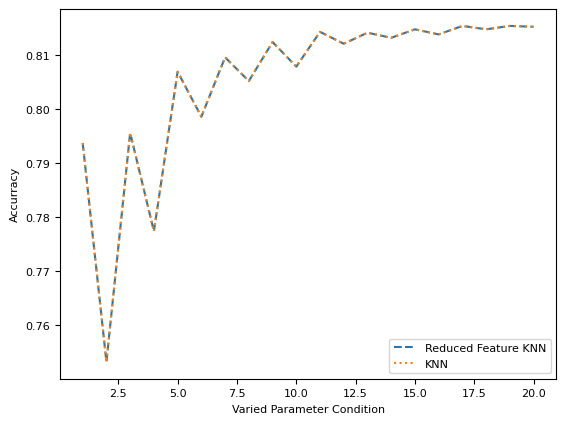

Plot 6:  Reduced Feature Set Computation Time Plot


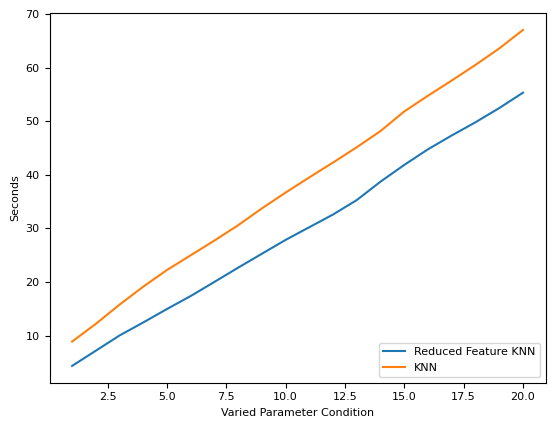

In [61]:
print('Plot 5:  KNN Comparison Accuracy Plot')
plt.plot(dfAccuracy['IF_KNN'], linestyle='dashed')
plt.plot(dfAccuracy['KNN'], linestyle='dotted')
plt.xlabel('Varied Parameter Condition')
plt.ylabel('Accurracy')
plt.legend(['Reduced Feature KNN','KNN'], loc=4)
plt.show()

print('Plot 6:  Reduced Feature Set Computation Time Plot')
plt.plot(dfTimes['IF_KNN'])
plt.plot(dfTimes['KNN'])
plt.xlabel('Varied Parameter Condition')
plt.ylabel('Seconds')
plt.legend(['Reduced Feature KNN', 'KNN'], loc=4)
plt.show()

#### Random Forest Plots

Plot 7:  Reduced Feature Set Accuracy Plot


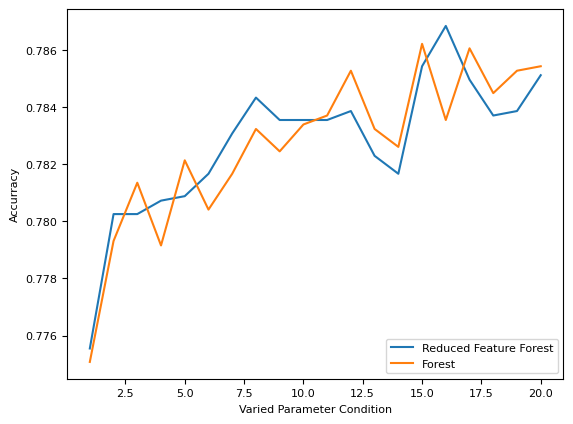

Plot 8:  Reduced Feature Set Computation Time Plot


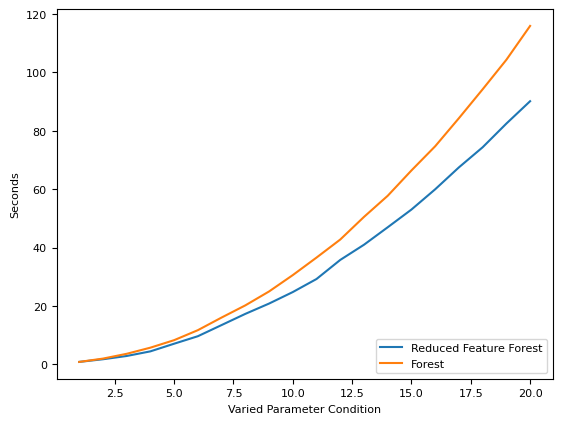

In [62]:
print('Plot 7:  Reduced Feature Set Accuracy Plot')
plt.plot(dfAccuracy['IF_Forest'])
plt.plot(dfAccuracy['Forest'])
plt.xlabel('Varied Parameter Condition')
plt.ylabel('Accurracy')
plt.legend(['Reduced Feature Forest', 'Forest'], loc=4)
plt.show()

print('Plot 8:  Reduced Feature Set Computation Time Plot')
plt.plot(dfTimes['IF_Forest'])
plt.plot(dfTimes['Forest'])
plt.xlabel('Varied Parameter Condition')
plt.ylabel('Seconds')
plt.legend(['Reduced Feature Forest', 'Forest'], loc=4)
plt.show()

#### Gradient Decent Plots

Plot 9:  Reduced Feature Set Accuracy Plot


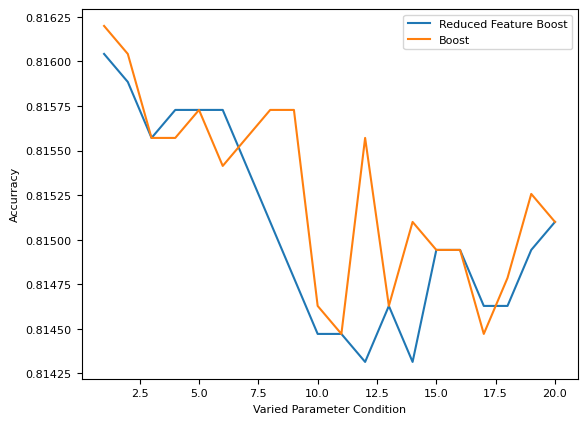

Plot 10:  Reduced Feature Set Computation Time Plot


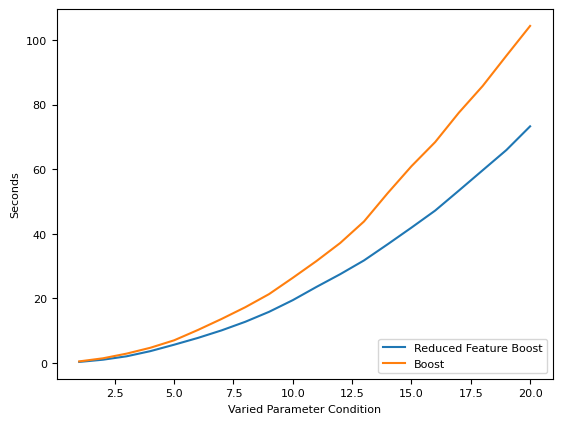

In [63]:
print('Plot 9:  Reduced Feature Set Accuracy Plot')
plt.plot(dfAccuracy['IF_Boost'])
plt.plot(dfAccuracy['Boost'])
plt.xlabel('Varied Parameter Condition')
plt.ylabel('Accurracy')
plt.legend(['Reduced Feature Boost', 'Boost'], loc=1)
plt.show()

print('Plot 10:  Reduced Feature Set Computation Time Plot')
plt.plot(dfTimes['IF_Boost'])
plt.plot(dfTimes['Boost'])
plt.xlabel('Varied Parameter Condition')
plt.ylabel('Seconds')
plt.legend(['Reduced Feature Boost', 'Boost'], loc=4)
plt.show()

### Discusion

#### Accuracy

Table 1 and Plot 1 provide a comparison of model accuracy based on the orginal data set of 61 features.  THe plot shows that the KNN and Gradient Boost models resulted in similiar perfromance.  Both models resulted in a classification accurracy of 81%. THe difference betwenn the two modles being that the Gradiant Boost arrived at the 81% accurracy much more qucjkly than the KNN model.  The random Forest model perfromed the worst out of the three with its accuacy topping out at ~78%.  Similiar to the Gradiant Boost model, the Random Forest the accurracy levels were arrived at more quckly tha the KNN model.

The feature importance method from the Random Forest classifier showed that approximately 22 of the 61 features had no impact on the models.  The features removed were the victim sex and the vast majority of the hours of the day.  This makes sense sone most of the murders occurred in the midnight and early monring hours. Expectaions were that the models would perform better with the feature reduction.  THe models were rebuilt and run on the reduced feature set.

Table 3 and Plots 3, 5, 7 and 9 detail the accurracy cmoparisions between models, as well as individual model comparisons between feature set sizes.  Expectatiosn were that the accurracy would improve given the reduced feature set, however this was noit the case.  For all three models the accuracy between the feature set sizes were virtually identical.  The KNN model resulted in an exact overlay and the tree models has minimal variations.  These variations can be attributed to the randomness in the test training and test sets used in the individual tree for each model.

Althogh not intially expected, the tracking of the accuaracies between feature set sizes makes sense.  For the KNN model, the unimportant featues would never fallen in the nearest neighhbor group from the offset.  They would have been outside the group as they had no influence on the model.  And for the tree models, the unimportant fetures would have been pruned out very early in the process, again with no influence on themodel,removing them had no impact on the accuracy.  Furthermore, the fact that the unimportant features were removed from the tree models in earlyin the classification, that explains why the varian in accuraccy in those models was less than the KNN model.  The KNN model had to progress through all ks looking at all points, where as the treemodels elimnate unimportant features at the offset.


#### Computational Time
Table 2 and Plot 2 provide insight into the computational resources, in terms of computation time, required for each model based on the orginal 61 features.  The KNN model perfromed worst in the lower condition (lower k) state than both the Random Forest and Gradient Boos Models.  However at the k~12 and learner count of 300 all three model required about the same comutational resources.  This was the crossover point where the KNN mode  began to outperfrom the tree models requiring less resources as the k value and number of learners increased.

Table 4 and plots 4, 6, 8 and to provide a view of the computational resources required across and within models based on the feature set sizes.  The results of these comparisons was more in line with intial expectations.  Plot 4 shows that the comparison between models at the reduceced feature set size had very similiar shapes.  However, the computational resourses, as expected, were reduced by 17%, 21% and 29% for the KNN, Random Forest and Gradiant Boostmodels repectively.

PLots 6 8 and 10 provide a side by side comparison for each of the models.  These plots clearly show the reduction on computational resources required for the reduced feature set size.  Addtionally the maginitude of the changes fallig line with expectations.  The KNN model still had to calculate up to 20 nearest neighbors, just with a reduced feature set, still faily expensive as k grows.  On the other hand the tree models have the models benefitted more from the reduced feature set size because the pruning did not have to remove the unimportant features and was thus able to get to the optimal conditionmore quickly.

### Conclusion

In [ ]:
Random Forest Importance

Random Forests is a kind of Bagging Algorithm that aggregates a specified number of decision trees. 
The tree-based strategies used by random forests naturally rank by how well they improve the purity of the node, or in 
other words, a decrease in the impurity (Gini impurity) over all trees. Nodes with the greatest decrease in impurity 
happen at the start of the trees, while notes with the least decrease in impurity occur at the end of the trees. 
Thus, by pruning trees below a particular node, we can create a subset of the most important features.